# Investigating external forcing instability in GungHo for the TLE case

In [1]:
import warnings

warnings.filterwarnings("ignore")  # noqa

In [2]:
from functools import partial

In [3]:
from tqdm.notebook import tqdm

Scientific stack

In [4]:
import esmf_regrid
import iris
import iris.coord_systems
import iris.fileformats
import iris.plot as iplt
import iris.quickplot as qplt
import matplotlib.colors as mcol
import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt
import numpy as np
from esmf_regrid.experimental.unstructured_scheme import (
    MeshToGridESMFRegridder,
    regrid_unstructured_to_rectilinear,
)
from iris.experimental.ugrid import PARSE_UGRID_ON_LOAD

# from iris.experimental import stratify
from matplotlib.offsetbox import AnchoredText

aeolus

In [5]:
import aeolus
from aeolus.calc import spatial_mean, time_mean, zonal_mean
from aeolus.const import init_const
from aeolus.coord import get_cube_rel_days, get_xy_coords, roll_cube_pm180
from aeolus.io import create_dummy_cube, load_vert_lev
from aeolus.model import um
from aeolus.plot import subplot_label_generator, tex2cf_units
from aeolus.subset import extract_last_n_days

In [6]:
from ipywidgets import interact

In [ ]:
%load_ext watermark

%watermark
%watermark -iv

Last updated: 2022-10-27T16:55:59.364605+00:00

Python implementation: CPython
Python version       : 3.8.13
IPython version      : 8.5.0

Compiler    : GCC 10.3.0
OS          : Linux
Release     : 4.15.0-194-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 192
Architecture: 64bit

iris       : 3.3.0
matplotlib : 3.6.1
esmf_regrid: 0.5.0
numpy      : 1.23.4
aeolus     : 0.4.15



In [8]:
from pouch.plot import (
    KW_AUX_TTL,
    KW_MAIN_TTL,
    KW_SBPLT_LABEL,
    KW_ZERO_LINE,
    KW_SYM0,
    figsave,
    linspace_pm1,
    use_style,
)

KW_SYM0 = {**KW_SYM0, "cmap": "seismic"}

local scripts

In [9]:
import mypaths
from lfric_util import add_equally_spaced_height_coord, clean_attrs, ugrid_spatial_mean

### Some global definitions

Apply a custom `matplotlib` style.

In [10]:
use_style()

Common directory where to save plots.

In [11]:
plot_dir = mypaths.plot

Load the data into a cube list

In [12]:
vert_lev_theta = load_vert_lev(mypaths.vert_um / "vertlevs_L38_29t_9s_40km")
vert_lev_rho = load_vert_lev(mypaths.vert_um / "vertlevs_L38_29t_9s_40km", "rho")

In [13]:
test_dir = "tle_test_c"

In [14]:
with PARSE_UGRID_ON_LOAD.context():
    # cl_init = iris.load(mypaths.results_lfric / "external_forcing" / sim_label / "base" / "1"/"lfric_initial.nc")
    cl_init = iris.load(f"/home/ds591/gungho_runs/{test_dir}/lfric_initial.nc")    

Select the run configuration

In [15]:
def load_lfric_data(sim_label, subdir="base"):
    # fnames = sorted(
    #     (mypaths.results_lfric / "external_forcing" / sim_label / subdir).glob(f"*/lfric_diag.nc"),
    #     key=lambda x: int(x.parent.name),
    # )
    # fnames = fnames[-10:]
    fnames = [f"/home/ds591/gungho_runs/{test_dir}/lfric_diag.nc"]
    # print(len(fnames))
    with PARSE_UGRID_ON_LOAD.context():
        cl_raw = iris.load(fnames)

        for cube in cl_raw:
            try:
                cube.attributes.pop("timeStamp")
                cube.attributes.pop("uuid")
            except KeyError:
                pass
        return cl_raw.concatenate(check_aux_coords=False)


def load_um_data(sim_label, subdir=""):
    fnames = sorted((mypaths.results_um / subdir).glob("umglaa.p*"))
    return iris.load(fnames)

In [16]:
SIM_CASES = {
    "tle": {"title": "TLE", "planet": "earth"},
    # "ben2": {"title": "Ben 2", "planet": "ben2"},
}

MODELS = {
    # "um": {"title": "UM", "get_files": load_um_data, "kw_plt": {"linestyle": "-"}},
    "lfric": {"title": "LFRic", "get_files": load_lfric_data, "kw_plt": {"linestyle": "--"}},
}
const = init_const("earth")#, directory=mypaths.const)
# kappa = const.dry_air_gas_constant / const.dry_air_spec_heat_press

In [17]:
runs = {}
for model_key, model_prop in tqdm(MODELS.items()):
    runs[model_key] = {}

    for sim_label, sim_prop in SIM_CASES.items():
        runs[model_key][sim_label] = model_prop["get_files"](sim_label, subdir="base")

  0%|          | 0/1 [00:00<?, ?it/s]

In [18]:
def qplt_map_scatter(cube, ax=None, **kw_scatter):
    if ax is None:
        ax = plt.axes()
    fig = ax.figure
    # This doesn't work because lons and lats in the mesh are of size N+2
    # while the data array is of size N
    # lons, lats = cube.mesh.node_coords
    # lons, lats = lons.points, lats.points
    lons = cube.coord("longitude").points
    lats = cube.coord("latitude").points
    mappable = ax.scatter(lons, lats, c=cube.data, **kw_scatter)
    fig.colorbar(mappable, ax=ax)

In [19]:
exner = cl_init.extract_cube("exner_pressure")
theta = cl_init.extract_cube("air_potential_temperature")
exner_fl = exner.interpolate([("half_levels", theta.coord("full_levels").points)], iris.analysis.Linear())
exner_fl.coord("half_levels").rename("full_levels")

In [20]:
temp = theta.copy(data=theta.data * exner_fl.data)
temp.rename(um.temp)

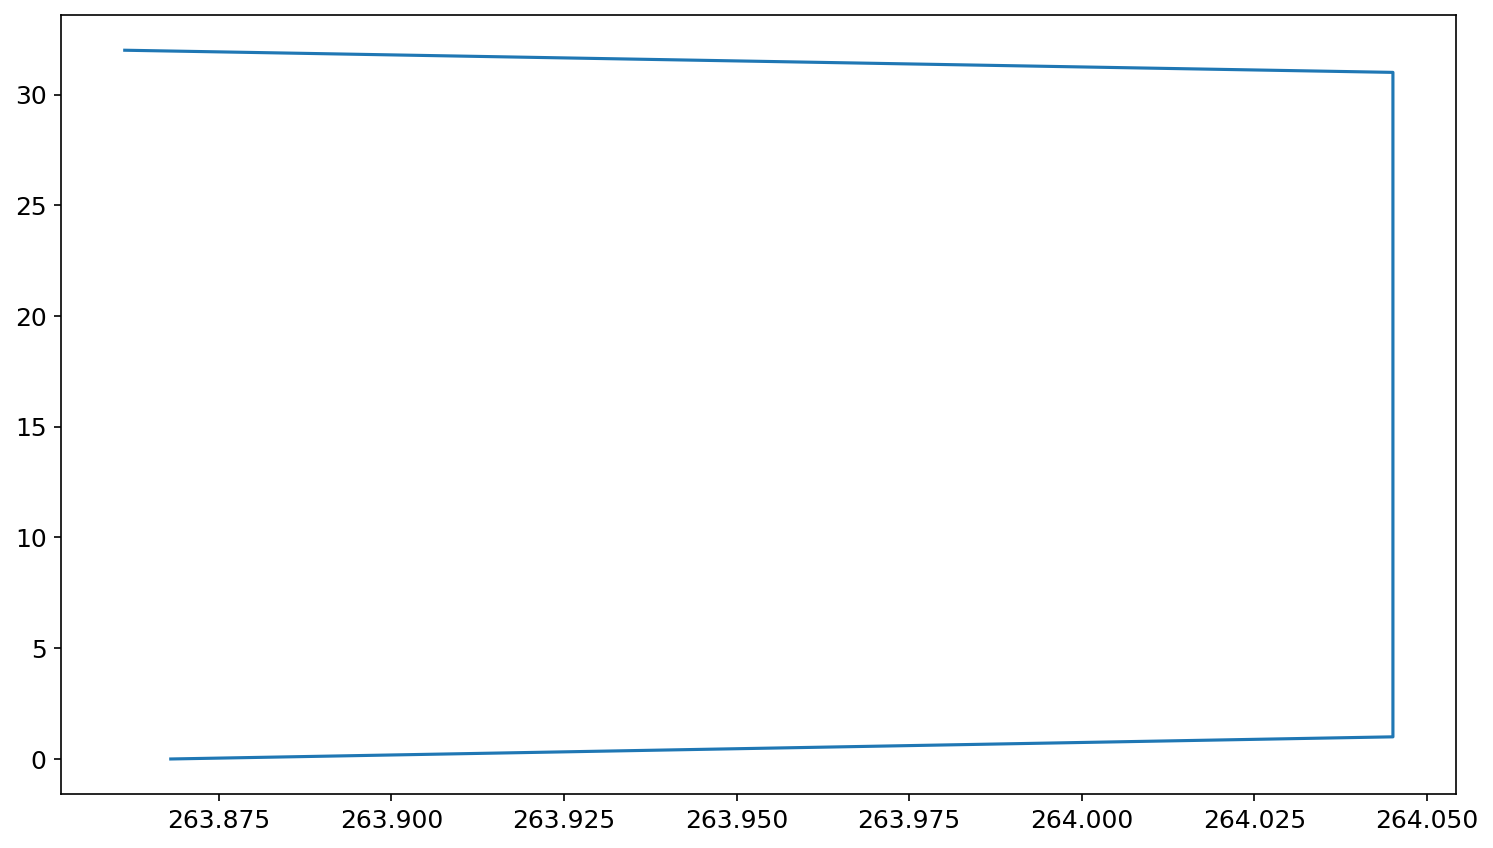

In [21]:
cube = temp
plt.plot(cube[:, 0].data, cube.coord("full_levels").points)

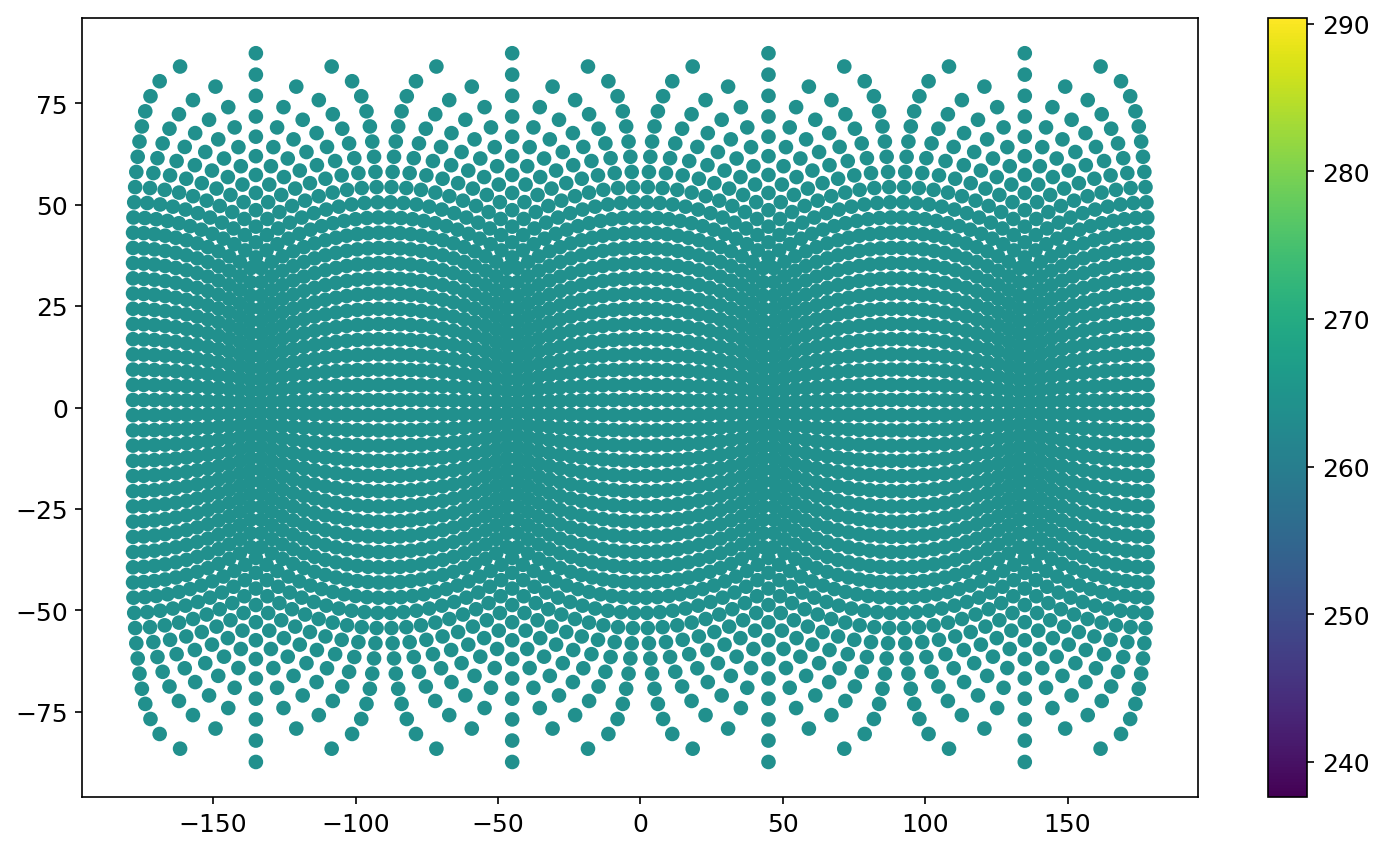

In [22]:
qplt_map_scatter(temp[0, ...], vmin=264, vmax=264)

In [23]:
exner = runs[model_key][sim_label].extract_cube("exner_pressure")
theta = runs[model_key][sim_label].extract_cube("air_potential_temperature")
exner_fl = exner.interpolate([("half_levels", theta.coord("full_levels").points)], iris.analysis.Linear())
exner_fl.coord("half_levels").rename("full_levels")

In [24]:
temp = theta.copy(data=theta.data * exner_fl.data)
temp.rename(um.temp)

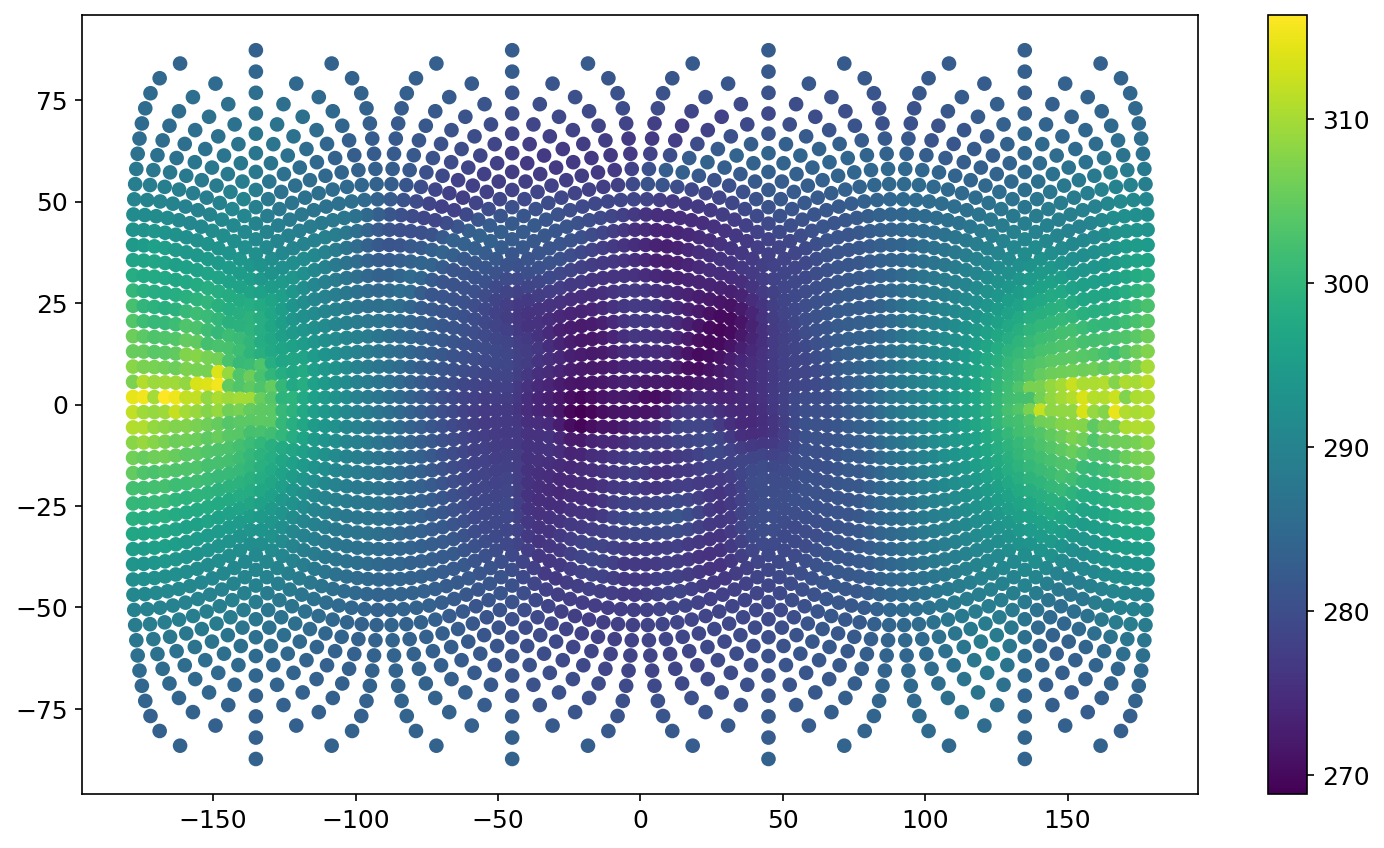

In [27]:
qplt_map_scatter(temp[-2, 1, ...])

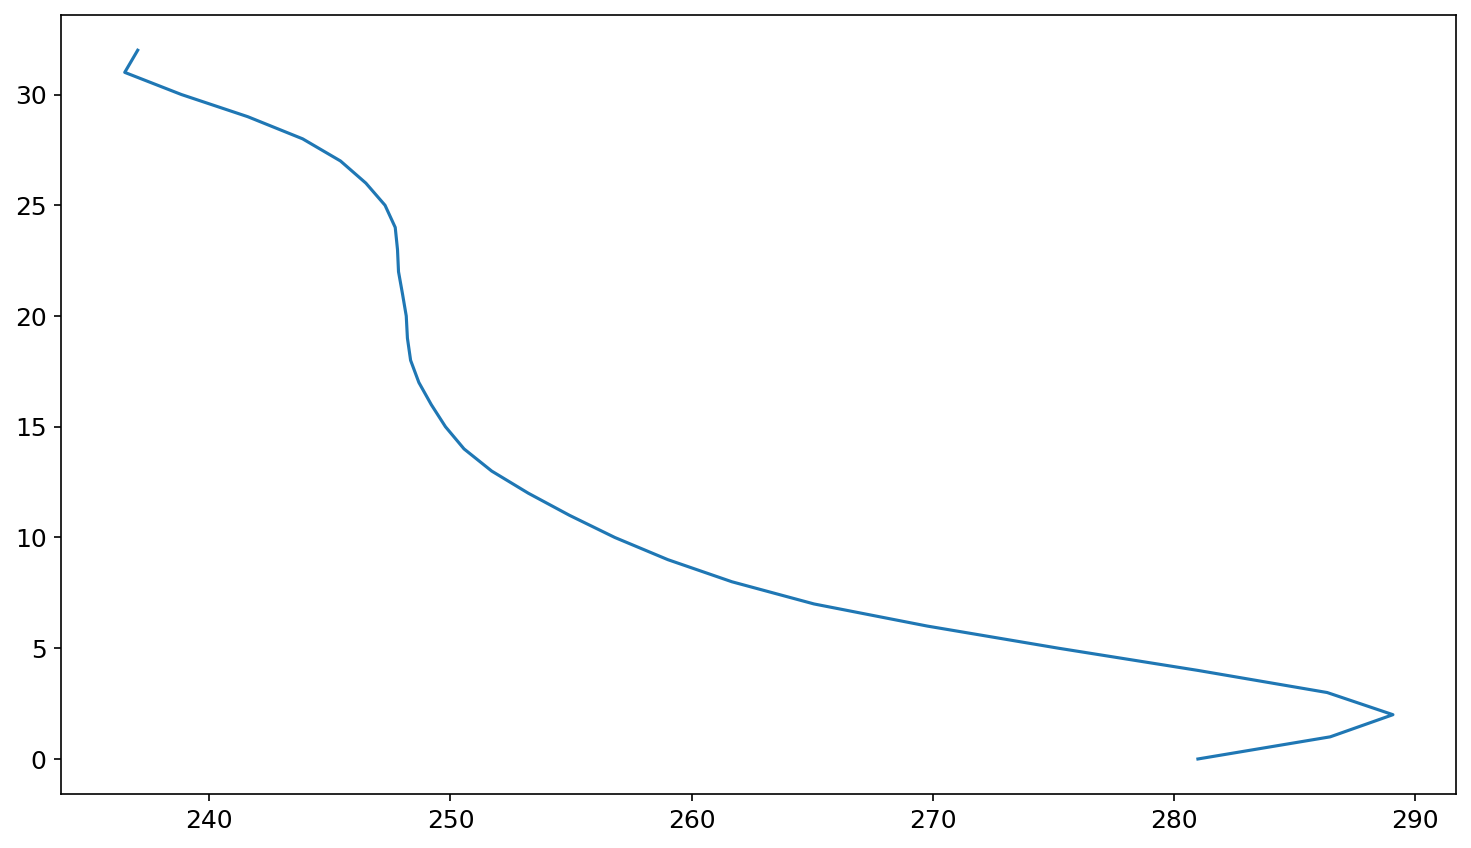

In [29]:
cube = temp
plt.plot(ugrid_spatial_mean(cube[-1,...]).data, cube.coord("full_levels").points)

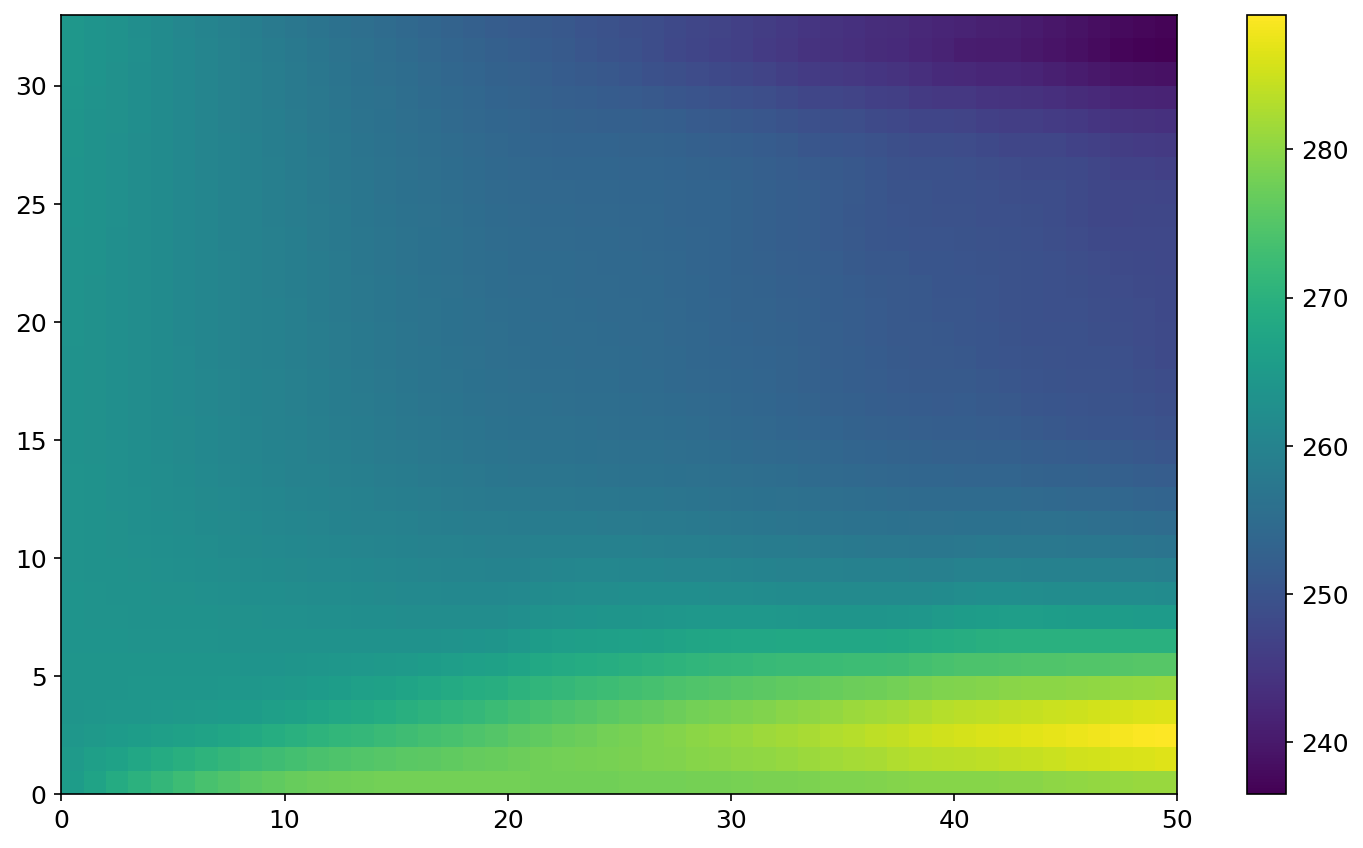

In [28]:
plt.pcolormesh(ugrid_spatial_mean(temp).data.T)
plt.colorbar()

In [18]:
def extract_location(cube, model_key, loc_prop):
    if model_key == "um":
        return cube.interpolate(
            [
                ("latitude", loc_prop["coord"]["latitude"]),
                ("longitude", loc_prop["coord"]["longitude"]),
            ],
            iris.analysis.Linear(),
        )
    elif model_key == "lfric":
        return cube.extract(iris.Constraint(**loc_prop["coord"]))[..., 0]

In [21]:
sim_label = "tle"
the_run = runs["lfric"][sim_label]

In [22]:
for cube in the_run.extract(
    [
        "surface_tile_temperature",
        "air_potential_temperature",
        "eastward_wind",
        "northward_wind",
        "vertical wind on physics points",
    ]
):
    print(f"{cube.long_name:<50} | {cube.var_name:<20}")

air_potential_temperature                          | theta               
physics U wind on W3 points                        | u_in_w3             
physics V wind on W3 points                        | v_in_w3             


In [19]:
t_sfc = the_run.extract_cube("surface_tile_temperature")[:, 9, :]

# theta_at_sfc = the_run.extract_cube("theta").extract(iris.Constraint(**{um.z: 0}))

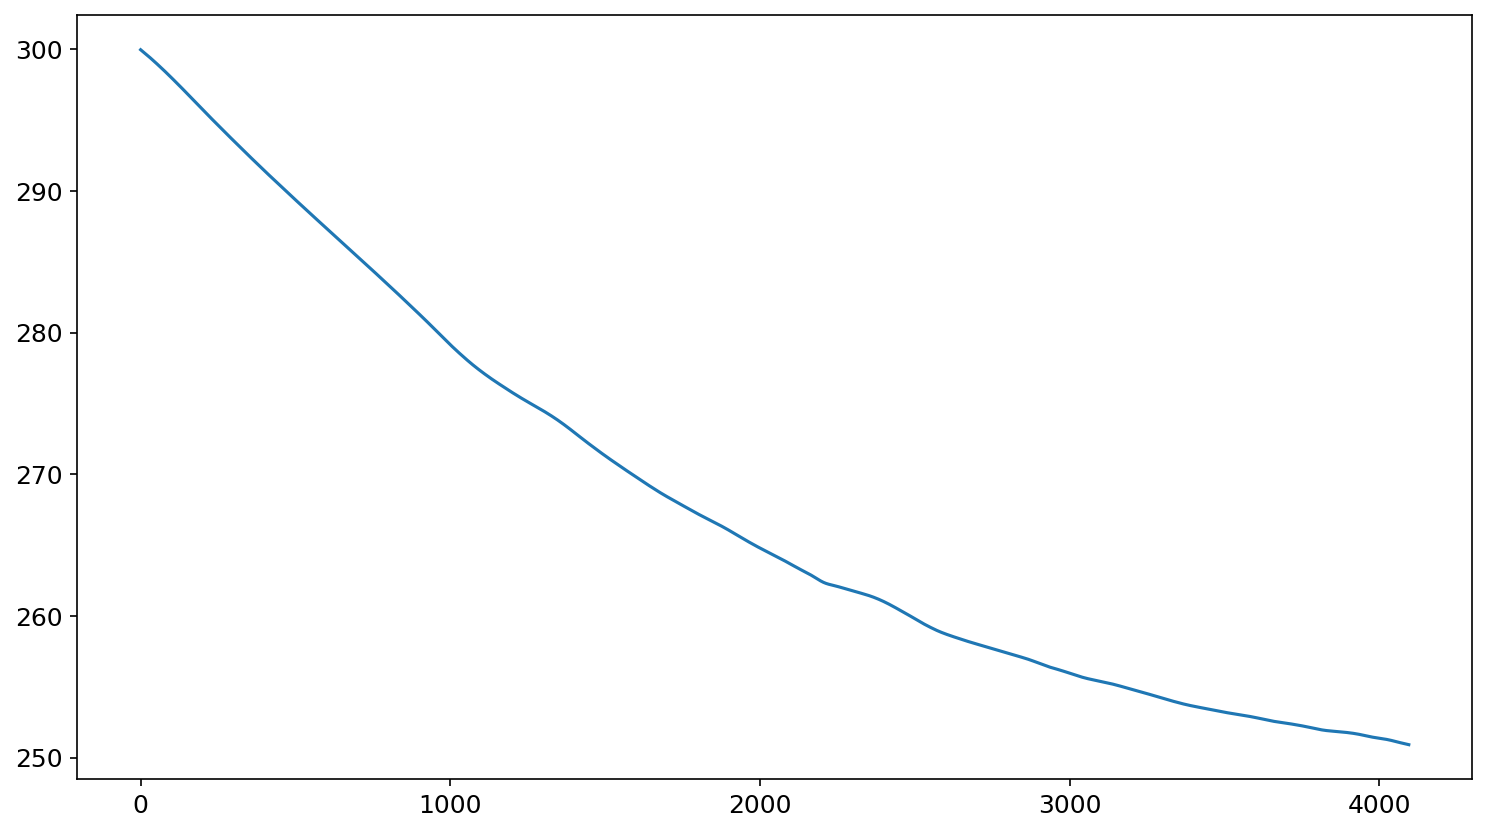

In [24]:
plt.plot(ugrid_spatial_mean(t_sfc).data)

In [33]:
lons = t_sfc.coord(um.x).points
lats = t_sfc.coord(um.y).points

In [34]:
# lons, lats = cube.mesh.node_coords

In [35]:
cmap = plt.cm.viridis.copy()
cmap.set_over('r')
cmap.set_under('b')

In [25]:
set([i.name() for i in the_run])

{'Indicates which other faces neighbor each face',
 'Maps every face to its edges.',
 'air_density',
 'air_potential_temperature',
 'air_pressure',
 'air_pressure_at_mean_sea_level',
 'divergence_of_wind',
 'eastward_wind',
 'exner_pressure',
 'longwave_heating_rate',
 'neighbor faces for edges',
 'northward_wind',
 'physics W wind on W3 points',
 'potential_temperature_increment_from_bl_scheme',
 'shortwave_heating_rate',
 'surface_downward_clear_longwave_flux_radiative_timestep',
 'surface_downward_clear_shortwave_flux_radiative_timestep',
 'surface_downward_longwave_flux',
 'surface_downward_shortwave_flux',
 'surface_net_longwave_flux_radiative_timestep',
 'surface_net_shortwave_flux_radiative_timestep',
 'surface_sensible_heat_flux',
 'surface_tile_temperature',
 'surface_upward_clear_longwave_flux_radiative_timestep',
 'surface_upward_clear_shortwave_flux_radiative_timestep',
 'temperature_increment_from_bl_scheme',
 'theta_increment_from_radiation',
 'toa_direct_shortwave_flux',

In [30]:
sw_hr = the_run.extract_cube("shortwave_heating_rate")
lw_hr = the_run.extract_cube("longwave_heating_rate")

In [28]:
sw_hr_sm = ugrid_spatial_mean(sw_hr)

In [31]:
lw_hr_sm = ugrid_spatial_mean(lw_hr)

In [48]:
@interact(it=(0, sw_hr.coord("time").shape[0]-1))
def f(it=-1):
    arr = the_run.extract_cube("w_physics").data[it, -10, ...]
    fig, ax = plt.subplots()
    h = ax.scatter(lons, lats, c=arr, cmap=cmap, vmin=-.1, vmax=.1)
    fig.colorbar(h)
    ax.set_title(f"{arr.min():.1f} | {arr.max():.1f}");

interactive(children=(IntSlider(value=0, description='it', max=4095), Output()), _dom_classes=('widget-interac…

In [15]:
cmap_temp = plt.cm.plasma.copy()
cmap_temp.set_extremes(under="b", over="r", bad="C7")
cmap_pres = plt.cm.viridis.copy()
cmap_pres.set_extremes(under="b", over="r", bad="C7")
cmap_div_log = plt.cm.RdBu_r.copy()
cmap_div_log.set_extremes(under="b", over="r", bad="C7")

## Animated maps

In [56]:
vrbls = {
    "grid_surface_temperature": {
        "recipe": lambda cl: cl.extract_cube("grid_surface_temperature"),
        "tex_units": "$K$",
        "kw_plt": dict(vmin=300, vmax=350, cmap=cmap_temp),
    },
    "theta_lev27": {
        "recipe": lambda cl: cl.extract_cube("theta").extract(
            iris.Constraint(full_levels=27)
        ),
        "tex_units": "$K$",
        "kw_plt": dict(vmin=345, vmax=360, cmap=cmap_temp),
    },
    "w_in_wth_lev33": {
        "recipe": lambda cl: cl.extract_cube("w_in_wth").extract(
            iris.Constraint(full_levels=33)
        ),
        "tex_units": "$m$ $s^{-1}$",
        "kw_plt": dict(
            cmap=cmap_div_log,
            norm=mcol.SymLogNorm(linthresh=0.1, vmin=-10, vmax=10),
        ),
    },
    "pmsl": {
        "recipe": lambda cl: cl.extract_cube("pmsl") * 1e-2,
        "tex_units": "$hPa$",
        "kw_plt": dict(vmin=940, vmax=990, cmap=cmap_pres),
    },
    "divergence_lev33": {
        "recipe": lambda cl: cl.extract_cube("divergence").extract(
            iris.Constraint(half_levels=32.5)
        )
        * 1e4,
        "tex_units": "$10^{-4}$ $s^{-1}$",
        "kw_plt": dict(vmin=-0.1, vmax=0.1, cmap=cmap_div_log),
    },
}

In [32]:
the_run = runs["lfric"][sim_label]
timestep = 1800
mesh_dt_label = f"C24_dt-{timestep}p0"

In [33]:
import matplotlib as mpl
import matplotlib.animation

In [57]:
vrbls_to_plot = ["theta_lev27"]

In [58]:
t_step_start = 0
t_step_end = 134
t_restart = 23041

ncols = len(vrbls_to_plot)
nrows = 1
fig = plt.figure(figsize=(12 * ncols, 5 * nrows), constrained_layout=True)
axd = fig.subplot_mosaic(
    [[f"{vrbl_key}"] for vrbl_key in vrbls_to_plot],
)


def _make_frame(t_step):
    iletters = subplot_label_generator()
    for ax_key, ax in axd.items():
        ax.clear()
        if "-cax" not in ax_key:
            ax.set_title(next(iletters), **KW_SBPLT_LABEL)
            ax.set_xlim(-180, 180)
            ax.set_xlim(-90, 90)

    for vrbl_key in vrbls_to_plot:
        vrbl_prop = vrbls[vrbl_key]
        cube = vrbl_prop["recipe"](the_run)
        cube_single_t_step = cube[t_step, ...]
        lons = cube_single_t_step.coord(um.x).points
        lats = cube_single_t_step.coord(um.y).points
        # cube_single_t_step.convert_units(tex2cf_units(vrbl_prop["tex_units"]))

        ax = axd[vrbl_key]
        ax.add_artist(
            AnchoredText(f"{vrbl_key} [{vrbl_prop['tex_units']}]", loc="upper left")
        )
        ax.set_title(
            f"Time step: {t_restart + t_step:<5} (~{(t_restart + t_step)*timestep/86400:<4.1f} days)",
            **KW_AUX_TTL,
        )

        _p0 = ax.scatter(
            lons,
            lats,
            c=cube_single_t_step.data,
            **vrbl_prop["kw_plt"],
        )
        # cbar = fig.colorbar(_p0, cax=axd[f"{vrbl_key}-cax"], extend="both")


_make_frame(t_step_start)
frames = t_step_end
anim = mpl.animation.FuncAnimation(
    fig, _make_frame, frames=frames, interval=100, blit=False
)
imgname = f"lfric_atm_thai_{sim_label}_{mesh_dt_label}__{'_'.join(vrbls_to_plot)}"
anim.save(
    plot_dir / f"{imgname}_{t_step_start + t_restart}-{(frames+t_restart):03d}d.mp4"
)

plt.close()

## TZ profiles

In [49]:
the_run = runs["lfric"][sim_label]

In [50]:
vrbls = {
    "theta": {
        "recipe": lambda cl: cl.extract_cube("theta").extract(
            iris.Constraint(full_levels=lambda x: x < 30)
        ),
        "tex_units": "$K$",
        "kw_plt": dict(vmin=300, vmax=400, cmap=cmap_temp),
    },
    "w_in_wth": {
        "recipe": lambda cl: cl.extract_cube("upward_air_velocity"),
        "tex_units": "$m$ $s^{-1}$",
        "kw_plt": dict(
            cmap=cmap_div_log,
            norm=mcol.SymLogNorm(linthresh=0.1, vmin=-10, vmax=10),
        ),
    },
}

In [51]:
locations = {
    "crash": {"title": "Crash point", "coord": dict(latitude=5.59808655, longitude=5.625)},
    "ssp": {"title": "Substellar point", "coord": dict(latitude=0, longitude=0)},
    "random": {"title": "Random day-side point", "coord": dict(latitude=-20, longitude=-20)},
}

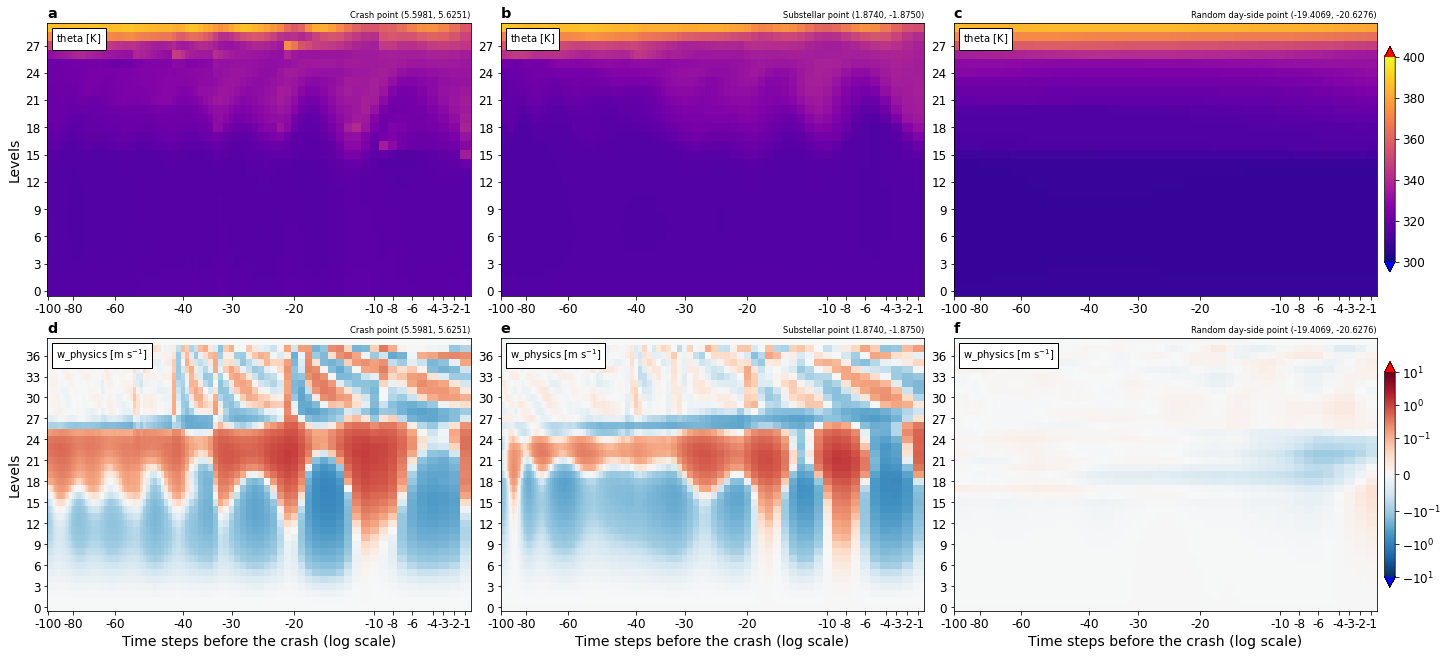

In [54]:
fig = plt.figure(figsize=(20, 9), constrained_layout=True)
axd = fig.subplot_mosaic(
    [
        [f"{vrbl_key}-{loc_key}" for loc_key in locations] + [f"{vrbl_key}-cax"]
        for vrbl_key in vrbls
    ],
    gridspec_kw=dict(width_ratios=[1, 1, 1, 0.025]),
)

last_n_timesteps = 100
x_log_base = 1.025
xticks = np.concatenate(
    [
        np.arange(0, 60, 20),
        np.arange(60, 90, 10),
        np.arange(90, 97, 2),
        np.arange(97, 100, 1),
    ]
)

tslice = slice(-last_n_timesteps, None, None)
t_points = np.arange(last_n_timesteps)
t_points = x_log_base ** np.abs(t_points)


iletters = subplot_label_generator()
for ax_key, ax in axd.items():
    if "-cax" not in ax_key:
        ax.set_title(next(iletters), **KW_SBPLT_LABEL)
        if ax.get_subplotspec().is_last_row():
            ax.set_xlabel("Time steps before the crash (log scale)")
        if ax.get_subplotspec().is_first_col():
            ax.set_ylabel("Levels")
        ax.set_xticks(x_log_base**xticks)
        ax.set_xticklabels(xticks - last_n_timesteps)

for vrbl_key, vrbl_prop in vrbls.items():
    cube = vrbl_prop["recipe"](the_run)
    for loc_key, loc_prop in locations.items():
        cube_single_node = cube.extract(iris.Constraint(**loc_prop["coord"]))[
            ..., 0
        ]
        cell_loc_str = f'{cube_single_node.coord("latitude").points[0]:.4f}, {cube_single_node.coord("longitude").points[0]:.4f}'
        # cube_single_node.convert_units(tex2cf_units(vrbl_prop["tex_units"]))
        z_points = cube_single_node.coord("full_levels").points

        ax = axd[f"{vrbl_key}-{loc_key}"]
        ax.set_yticks(z_points[::3])
        ax.add_artist(
            AnchoredText(f"{vrbl_key} [{vrbl_prop['tex_units']}]", loc="upper left")
        )
        ax.set_title(f'{loc_prop["title"]} ({cell_loc_str})', **KW_AUX_TTL)

        _p0 = ax.pcolormesh(
            t_points,
            z_points,
            cube_single_node.data[tslice, ...].T,
            **vrbl_prop["kw_plt"],
        )
        cbar = fig.colorbar(_p0, cax=axd[f"{vrbl_key}-cax"], extend="both")

In [55]:
figsave(
    fig,
    plot_dir
    / f"lfric_atm_thai_{sim_label}_{mesh_dt_label}__{'_'.join(vrbls)}__{'_'.join(locations)}",
)

Saved to ../plots/lfric_atm_thai_ben1_C24_dt-1800p0__theta_w_physics__crash_ssp_random.png


### Linear time scale

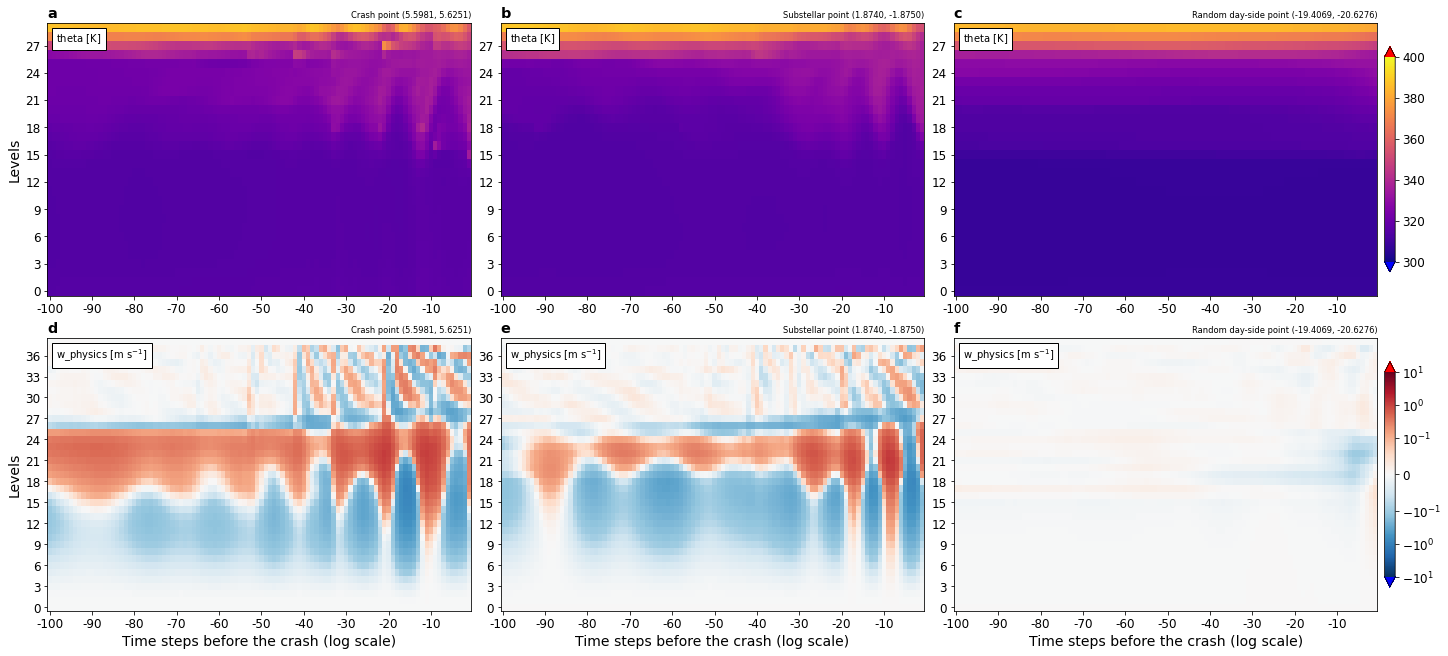

In [59]:
fig = plt.figure(figsize=(20, 9), constrained_layout=True)
axd = fig.subplot_mosaic(
    [
        [f"{vrbl_key}-{loc_key}" for loc_key in locations] + [f"{vrbl_key}-cax"]
        for vrbl_key in vrbls
    ],
    gridspec_kw=dict(width_ratios=[1, 1, 1, 0.025]),
)

last_n_timesteps = 100

tslice = slice(-last_n_timesteps, None, None)
t_points = np.arange(last_n_timesteps)
xticks = np.concatenate(
    [
        np.arange(0, 100, 10),
    ]
)

iletters = subplot_label_generator()
for ax_key, ax in axd.items():
    if "-cax" not in ax_key:
        ax.set_title(next(iletters), **KW_SBPLT_LABEL)
        if ax.get_subplotspec().is_last_row():
            ax.set_xlabel("Time steps before the crash (log scale)")
        if ax.get_subplotspec().is_first_col():
            ax.set_ylabel("Levels")
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticks - last_n_timesteps)

for vrbl_key, vrbl_prop in vrbls.items():
    cube = vrbl_prop["recipe"](the_run)
    for loc_key, loc_prop in locations.items():
        cube_single_node = cube.extract(iris.Constraint(**loc_prop["coord"]))[..., 0]
        cell_loc_str = f'{cube_single_node.coord("latitude").points[0]:.4f}, {cube_single_node.coord("longitude").points[0]:.4f}'
        # cube_single_node.convert_units(tex2cf_units(vrbl_prop["tex_units"]))
        z_points = cube_single_node.coord("full_levels").points

        ax = axd[f"{vrbl_key}-{loc_key}"]
        ax.set_yticks(z_points[::3])
        ax.add_artist(
            AnchoredText(f"{vrbl_key} [{vrbl_prop['tex_units']}]", loc="upper left")
        )
        ax.set_title(f'{loc_prop["title"]} ({cell_loc_str})', **KW_AUX_TTL)

        _p0 = ax.pcolormesh(
            t_points,
            z_points,
            cube_single_node.data[tslice, ...].T,
            **vrbl_prop["kw_plt"],
        )
        cbar = fig.colorbar(_p0, cax=axd[f"{vrbl_key}-cax"], extend="both")

In [60]:
timestep = 1800
mesh_dt_label = f"C24_dt-{timestep}p0"
figsave(
    fig,
    plot_dir
    / f"lfric_atm_thai_{sim_label}_{mesh_dt_label}__{'_'.join(vrbls)}__{'_'.join(locations)}__linear_time",
)

Saved to ../plots/lfric_atm_thai_ben1_C24_dt-1800p0__theta_w_physics__crash_ssp_random__linear_time.png


## Maps

In [16]:
vrbls = {
    "grid_surface_temperature": {
        "recipe": lambda cl: cl.extract_cube("grid_surface_temperature"),
        "tex_units": "$K$",
        "kw_plt": dict(vmin=300, vmax=350, cmap=cmap_temp),
    },
    "theta_lev27": {
        "recipe": lambda cl: cl.extract_cube("theta").extract(
            iris.Constraint(full_levels=27)
        ),
        "tex_units": "$K$",
        "kw_plt": dict(vmin=340, vmax=365, cmap=cmap_temp),
    },
    "w_in_wth_lev33": {
        "recipe": lambda cl: cl.extract_cube("w_in_wth").extract(
            iris.Constraint(full_levels=33)
        ),
        "tex_units": "$m$ $s^{-1}$",
        "kw_plt": dict(
            cmap=cmap_div_log,
            norm=mcol.SymLogNorm(linthresh=0.1, vmin=-10, vmax=10),
        ),
    },
    "pmsl": {
        "recipe": lambda cl: cl.extract_cube("pmsl") * 1e-2,
        "tex_units": "$hPa$",
        "kw_plt": dict(vmin=940, vmax=990, cmap=cmap_pres),
    },
    "divergence_lev33": {
        "recipe": lambda cl: cl.extract_cube("divergence").extract(
            iris.Constraint(half_levels=32.5)
        )
        * 1e4,
        "tex_units": "$10^{-4}$ $s^{-1}$",
        "kw_plt": dict(vmin=-0.1, vmax=0.1, cmap=cmap_div_log),
    },
}

In [109]:
t_steps = [0, 134]
t_restart = 23041

In [163]:
vrbls_to_plot = ["divergence_lev33"]

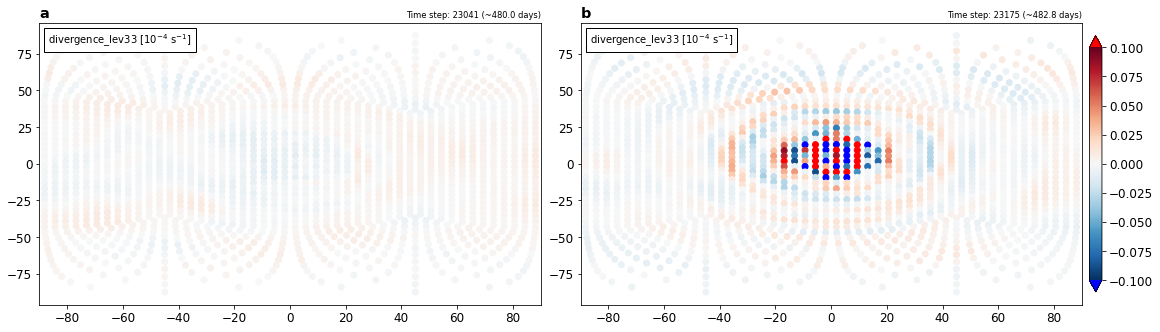

In [164]:
ncols = len(t_steps)
nrows = len(vrbls_to_plot)
fig = plt.figure(figsize=(8 * ncols, 4.5 * nrows), constrained_layout=True)
axd = fig.subplot_mosaic(
    [
        [f"{vrbl_key}-{t_step}" for t_step in t_steps] + [f"{vrbl_key}-cax"]
        for vrbl_key in vrbls_to_plot
    ],
    gridspec_kw=dict(width_ratios=[1] * ncols + [0.025]),
)

iletters = subplot_label_generator()
for ax_key, ax in axd.items():
    if "-cax" not in ax_key:
        ax.set_title(next(iletters), **KW_SBPLT_LABEL)
    ax.set_xlim(-180, 180)
    ax.set_xlim(-90, 90)

for vrbl_key in vrbls_to_plot:
    vrbl_prop = vrbls[vrbl_key]
    cube = vrbl_prop["recipe"](the_run)
    for t_step in t_steps:
        cube_single_t_step = cube[t_step, ...]
        lons = cube_single_t_step.coord(um.x).points
        lats = cube_single_t_step.coord(um.y).points
        # cube_single_t_step.convert_units(tex2cf_units(vrbl_prop["tex_units"]))

        ax = axd[f"{vrbl_key}-{t_step}"]
        ax.add_artist(
            AnchoredText(f"{vrbl_key} [{vrbl_prop['tex_units']}]", loc="upper left")
        )
        ax.set_title(
            f"Time step: {t_restart + t_step:<5} (~{(t_restart + t_step)*timestep/86400:.1f} days)",
            **KW_AUX_TTL,
        )

        _p0 = ax.scatter(
            lons,
            lats,
            c=cube_single_t_step.data,
            **vrbl_prop["kw_plt"],
        )
        cbar = fig.colorbar(_p0, cax=axd[f"{vrbl_key}-cax"], extend="both")
        # for loc_key, loc_prop in locations.items():
        #     cube_single_node = cube.extract(iris.Constraint(**loc_prop["coord"]))[
        #         ..., 0
        #     ]
        #     ax.scatter(
        #         cube_single_node.coord("longitude").points[0],
        #         cube_single_node.coord("latitude").points[0],
        #         s=2**8,
        #         facecolors="none",
        #         edgecolors="k",
        #         linewidths=3,
        #     )
        #     ax.scatter(
        #         cube_single_node.coord("longitude").points[0],
        #         cube_single_node.coord("latitude").points[0],
        #         s=2**8,
        #         facecolors="none",
        #         edgecolors="C9",
        #         linewidths=2,
        #     )

In [165]:
figsave(
    fig,
    plot_dir
    / f"lfric_atm_thai_{sim_label}_{mesh_dt_label}__{'_'.join(vrbls_to_plot)}__{'_'.join([str(i) for i in t_steps])}",
)

Saved to ../plots/lfric_atm_thai_ben1_C24_dt-1800p0__divergence_lev33__0_134.png
